In [2]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
# Import KNNImputer from sklearn
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



In [3]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")

In [4]:
# Display the number of missing values for each column
missing_values = d.isnull().sum()
missing_values_non_zero = missing_values[missing_values > 0]
# print("Missing values in each column (excluding zeros):\n", missing_values_non_zero)

# Imputation with KNN
imputer = KNNImputer(n_neighbors=5)
d_imputed = pd.DataFrame(imputer.fit_transform(d.select_dtypes(include='number')), columns=d.select_dtypes(include='number').columns)
# 将非数值型数据的列添加回d_imputed中
non_numeric_columns = d.select_dtypes(exclude='number').columns
d_imputed[non_numeric_columns] = d[non_numeric_columns]

# 现在d_imputed应该包含所有原始的变量了
missing_values_after_imputation = d_imputed.isnull().sum()
# print("Missing values in each column after imputation with KNN :\n ", missing_values_after_imputation)


In [5]:
# Convert dt_first_pi and dt_matr to datetime
d_imputed['dt_first_pi'] = pd.to_datetime(d_imputed['dt_first_pi'], format='%Y%m')
d_imputed['dt_matr'] = pd.to_datetime(d_imputed['dt_matr'], format='%Y%m')

# Calculate the loan term in months
d_imputed['loan_term_months'] = (d_imputed['dt_matr'].dt.year - d_imputed['dt_first_pi'].dt.year) * 12 + \
                         (d_imputed['dt_matr'].dt.month - d_imputed['dt_first_pi'].dt.month)
# print(d_imputed['loan_term_months'])


In [6]:
# Remove rows where 'cltv' is 999
removal_terms = (d_imputed['cltv'] != 999) & (d_imputed['dti'] != 999) & (d_imputed['ltv'] != 999)

d_imputed_cleaned = d_imputed[removal_terms]

In [7]:
# 综上，我们进行变量重整
# To remove the 'flag_fthb' column from your DataFrame
drop_list = ['flag_fthb','cd_msa','zipcode','prepaid','ppmt_pnlty','ltv','loan_term_months','dt_first_pi','dt_matr','id_loan']
d_imputed_cleaned_dropped = d_imputed_cleaned.drop(drop_list, axis=1)

In [8]:
# Assuming a DataFrame 'df' from the dataset you provided, we will apply One-Hot Encoding to categorical variables.

# First, let's define which columns are categorical based on the provided variable descriptions.
categorical_columns = ['channel', 'occpy_sts', 'prod_type', 'prop_type', 'loan_purpose','flag_sc']
# categorical_columns = ['channel']
# Apply One-Hot Encoding to categorical columns
d_imputed_cleaned_dropped_onehot = pd.get_dummies(d_imputed_cleaned_dropped, columns=categorical_columns)



In [9]:
def target_encode_columns(train_data, test_data, columns_to_encode = ['servicer_name', 'seller_name', 'st'], target_column = 'default'):
    """
    对指定的列进行目标编码，确保编码仅使用训练数据。
    
    参数:
    - train_data: 训练数据集的DataFrame
    - test_data: 测试数据集的DataFrame
    - columns_to_encode: 需要进行目标编码的列名列表
    - target_column: 目标变量的列名
    
    返回:
    - train_encoded: 编码后的训练数据集
    - test_encoded: 编码后的测试数据集
    """
    # 创建目标编码器实例
    encoder = TargetEncoder()
    
    # 深拷贝训练和测试数据集，避免修改原始DataFrame
    train_encoded = train_data.copy()
    test_encoded = test_data.copy()
    
    # 对每个指定列进行目标编码
    for column in columns_to_encode:
        # 使用训练数据拟合编码器
        encoder.fit(train_encoded[column], train_encoded[target_column])
        
        # 对训练和测试数据集的列进行转换
        train_encoded[column] = encoder.transform(train_encoded[column])
        test_encoded[column] = encoder.transform(test_encoded[column])
    
    return train_encoded, test_encoded

In [10]:
X = d_imputed_cleaned_dropped_onehot.drop('default', axis=1)
y = d_imputed_cleaned_dropped_onehot['default']
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

In [11]:
# 需要进行目标编码的列名列表
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# 将X_train和X_test合并回DataFrame形式，以便传递到自定义函数
train_data = X_train.join(y_train)
test_data = X_test

train_data.replace({True: 1, False: 0}, inplace=True)
test_data.replace({True: 1, False: 0}, inplace=True)

# 应用目标编码
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# 确保目标变量不在特征集中
X_train_encoded = train_encoded.drop('default', axis=1)
X_test_encoded = test_encoded
y_train_encoded = train_encoded['default']

print()

---
## 支持向量机

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np

# 创建管道
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('oversample', RandomOverSampler(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

# 设置参数网格
param_grid = {
    'oversample__sampling_strategy': ['auto', 0.5],
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': np.linspace(0.1, 2, 10)
}

# 设置交叉验证策略
cv_strategy = StratifiedKFold(n_splits=5)

# 创建GridSearchCV对象
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=cv_strategy, 
                           scoring='accuracy', 
                           verbose=1)

# 拟合GridSearchCV对象
grid_search.fit(X_train_encoded, y_train_encoded)

# 打印最佳参数和最佳得分
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# 使用最佳参数的模型进行预测
y_pred_train = grid_search.predict(X_train_encoded)
y_pred_test = grid_search.predict(X_test_encoded)

# 计算训练集和测试集的准确率
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# 打印训练集和测试集的准确率
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 生成和打印分类报告和混淆矩阵
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred_test))

# 生成ROC曲线
y_pred_proba = grid_search.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

##### 4.5 Support Vector Machine

This analysis utilizes a Support Vector Machine (SVM) model to classify loan default risks, using the `scikit-learn` and `imbalanced-learn` libraries. The pipeline incorporates `StandardScaler` for feature normalization, and `RandomOverSampler` to balance the class distribution by increasing the minority class instances. At the core is an `SVC` with a linear kernel, chosen for its effectiveness in high-dimensional spaces, with `probability=True` to enable ROC curve computations.

Training Accuracy: 0.7574212347477691
Test Accuracy: 0.7594108019639935

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86       600
         1.0       0.05      0.73      0.10        11

    accuracy                           0.76       611
   macro avg       0.52      0.74      0.48       611
weighted avg       0.98      0.76      0.85       611

Confusion Matrix (Test Set):


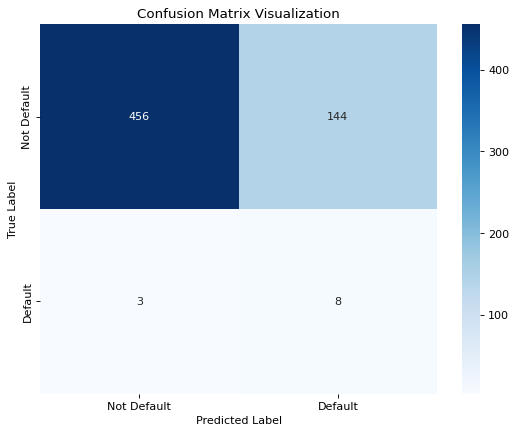

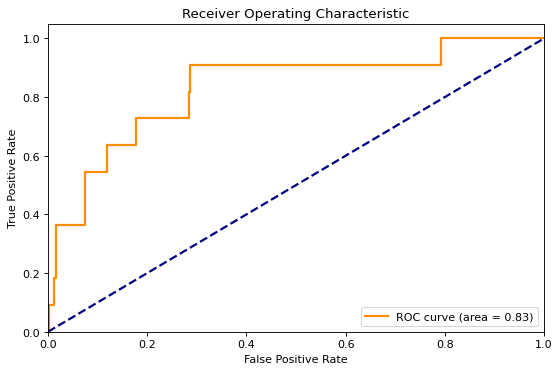

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# 创建一个包含SMOTE过采样和SVC模型的管道，并设置probability=True以便使用ROC曲线
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('oversample', RandomOverSampler(random_state=42)),
    ('svm', SVC(kernel='linear', random_state=42, probability=True))
])

# 拟合管道模型
pipeline.fit(X_train_encoded, y_train_encoded)

# 使用训练好的管道进行预测
y_pred_train = pipeline.predict(X_train_encoded)
y_pred_test = pipeline.predict(X_test_encoded)

# 计算训练集和测试集的准确率
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# 打印训练集和测试集的准确率
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 生成和打印分类报告和混淆矩阵
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix (Test Set):")

cm = confusion_matrix(y_test, y_pred_test)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Default', 'Default'], 
            yticklabels=['Not Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Visualization')
plt.show()
# 生成ROC曲线
y_pred_proba = pipeline.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The evaluation results of the classification model for loan default prediction present a mixed outcome. The model achieved a test accuracy of approximately 76%, with a stronger recall for the non-default class, indicated by 456 correct predictions out of 600. The recall for the default class is significantly lower, with only 3 out of 11 cases correctly identified, suggesting a potential model bias towards the majority class.

The confusion matrix visualizes this disparity, showing a high number of false positives for defaults. The ROC curve provides a more positive perspective, with an AUC of 0.83, suggesting the model's decent capability in distinguishing between classes. However, the low precision and recall for the default class highlight the need for model improvements or different approaches to better capture the minority class's characteristics and improve overall predictive performance.